# CMIP6 Intake

**Following steps are included in this script:**

1. Open DKRZ Cataloge and Save CMIP6 Catalog
2. Load Data with all Variables via Intake.
3. Save Data as netCDF

Saving each variable separately is prefered, however, saving more variables in a single file is also possible.

In [1]:
# ========== Packages ==========
import xarray as xr
import intake
import dask
import os
import pandas as pd
import numpy as np
import gcsfs

In [2]:
import sys
import os
import dask
import xarray as xr
from dask.diagnostics import ProgressBar

# Define the full path to the data_handling directory and the config file
data_handling_dir = '/work/ch0636/g300115/phd_project/common/src/data_handling'
config_dir = '/work/ch0636/g300115/phd_project/common/src'

# Add the directories to sys.path
sys.path.append(data_handling_dir)
sys.path.append(config_dir)

# Now import the functions from load_preprocessed_data.py and config
import load_data as ld
import save_data_as_nc as sd
from config import BASE_DIR, DEFAULT_MODEL, DEFAULT_VARIABLE, DEFAULT_TEMPORAL_RES, DEFAULT_EXPERIMENT

### Functions

In [3]:
from xmip.preprocessing import correct_lon, correct_units, parse_lon_lat_bounds, maybe_convert_bounds_to_vertex, maybe_convert_vertex_to_bounds

def pre_preprocessing(ds: xr.Dataset) -> xr.Dataset:
    """
    Preprocesses a CMIP6 dataset
    
    Parameters:
    ds (xr.Dataset): Input dataset
    
    Returns:
    xr.Dataset: Preprocessed dataset
    """
    
    def correct_coordinates(ds: xr.Dataset) -> xr.Dataset:
        """
        Corrects wrongly assigned data_vars to coordinates

        Parameters:
        ds (xr.Dataset): Input dataset

        Returns:
        xr.Dataset: Dataset with corrected coordinates
        """
        for co in ["lon", "lat"]:
            if co in ds.variables:
                ds = ds.set_coords(co)

        return ds.copy(deep=True)
 
    ds = correct_coordinates(ds)
    ds = correct_units(ds) 
    ds = parse_lon_lat_bounds(ds)
    ds = maybe_convert_bounds_to_vertex(ds)
    ds = maybe_convert_vertex_to_bounds(ds)
    return ds.copy(deep=True)

In [4]:
def replace_coordinates(new_coords, replace_coords):
    """
    Helper funtion to replace coordinates before merging.
    
    Args:
        new_coords (xr dataset): A dictionary of xarray datasets which gives the new coordinates.
        replace_coords (xr dataset): A dictionary of xarray datasets which coordinates will be replaced.

    Returns:
        replace_coords (xr dataset): The replace dictionary with the new coordinates copied from new_coords.
    """
    
    for coord in ['lon', 'lat', 'time']:
        if not new_coords[coord].equals(replace_coords[coord]):
            replace_coords[coord] = new_coords[coord]
        else:
            pass
    
    return replace_coords

In [5]:
def merge_source_id_data(ds_dict):
    """
    Merge datasets with the same source_id (name of the CMIP6 model) as CMIP6 data is stored in different table id's. This function is mainly used to merge two 
    different xarray datasets for 'table_id' Amon and Lmon into a single xarray dataset as this makes future investigations easier. Other table_id's
    can also be merged; however, be careful when the same variable exists in both datasets.

    Args:
        ds_dict (dict): A dictionary of xarray datasets, where each key is the name of the dataset 
                        and each value is the dataset itself.

    Returns:
        dict: A merged dictionary with a single dataset for each CMIP6 model/source_id.
    """
    
    merged_dict = {}
    for dataset_name, dataset in ds_dict.items():
        source_id = dataset.attrs['source_id']
        table_id = dataset.attrs['table_id']
        print(f"Merging dataset '{dataset_name}' with source_id '{source_id}' and table_id '{table_id}'...")
       
        if source_id in merged_dict:
            if source_id == merged_dict[source_id].attrs['source_id'] and table_id != merged_dict[source_id].attrs['table_id']:
                merg_model_name = merged_dict[source_id].attrs['intake_esm_dataset_key']
                merg_model_table_id = merged_dict[source_id].attrs['table_id']
                 
                # Replace coordinates lat, lon, time of dataset only when different to datasets in merged_dict
                dataset = replace_coordinates(merged_dict[source_id], dataset)

                # Merge data    
                with dask.config.set(**{'array.slicing.split_large_chunks': False}):
                    merged_dict[source_id] = xr.merge([merged_dict[source_id], dataset])

                if len(list(merged_dict.keys())) == 1:
                    print(f"Datasets '{merg_model_name}' ('{merg_model_table_id}') and '{dataset_name}' ('{table_id}') are merged to 'ds_dict' with key '{source_id}'.")
                else:
                    print(f"Datasets '{dataset_name}' ('{table_id}') is merged with 'ds_dict'.")

        else:
            merged_dict[source_id] = dataset
            print(f"Dataset '{dataset_name}' ('{table_id}') is saved in 'ds_dict'.")

    return merged_dict

In [6]:
def drop_redundant(ds_dict, drop_list): 
    """
    Remove redundant coordinates and variables from datasets in a dictionary.

    Parameters:
    ds_dict (dict): Dictionary containing dataset names as keys and xarray.Dataset objects as values.
    drop_list (list): List of redundant coordinate or variable names to be removed from the datasets.

    Returns:
    dict: Dictionary with the same keys as the input ds_dict and modified xarray.Dataset objects with redundant elements removed.
    """
    for ds_name, ds_data in ds_dict.items():
        
        if 'sdepth' in ds_data.coords:
            if 'depth' in ds_data.coords:
                ds_data = ds_data.drop('depth')
            if 'depth' in ds_data.dims:
                ds_data = ds_data.drop_dims('depth')
            ds_data = ds_data.rename({'sdepth': 'depth'})
            print(f'sdepth changed to depth for model {ds_data.source_id}')
            # Add comment about changes to data 
            if 'log' in ds_data.attrs:
                log_old = ds_data.attrs['log']
                ds_data.attrs['log'] = f'Coordinate name changed from sdepth to depth. // {log_old}'
            else:
                ds_data.attrs['log'] = 'Coordinate name changed from sdepth to depth.'
            
        if 'solth' in ds_data.coords:
            if 'depth' in ds_data.coords:
                ds_data = ds_data.drop('depth')
            if 'depth' in ds_data.dims:
                ds_data = ds_data.drop_dims('depth')
            ds_data = ds_data.rename({'solth': 'depth'})
            print(f'solth changed to depth for model {ds_data.source_id}')
            # Add comment about changes to data 
            if 'log' in ds_data.attrs:
                log_old = ds_data.attrs['log']
                ds_data.attrs['log'] = f'Coordinate name changed from solth to depth. // {log_old}'
            else:
                ds_data.attrs['log'] = 'Coordinate name changed from solth to depth.'
   
        
        if 'mrsol' in ds_data and 'depth' in drop_list or 'tsl' in ds_data and 'depth' in drop_list:
            drop_list.remove('depth')
                      
        for coord in drop_list:
            if coord in ds_data.coords:
                ds_data = ds_data.drop(coord).squeeze()
                print(f'Dropped coordinate: {coord}')
                # Add comment about changes to data 
                if 'log' in ds_data.attrs:
                    log_old = ds_data.attrs['log']
                    ds_data.attrs['log'] = f'Dropped: {coord}. // {log_old}'
                else:
                    ds_data.attrs['log'] = f'Dropped: {coord}.'
            if coord in ds_data.variables:
                ds_data = ds_data.drop_vars(coord).squeeze()
                print(f'Dropped variable: {coord}')
                # Add comment about changes to data 
                if 'log' in ds_data.attrs:
                    log_old = ds_data.attrs['log']
                    ds_data.attrs['log'] = f'Dropped: {coord}. // {log_old}'
                else:
                    ds_data.attrs['log'] = f'Dropped: {coord}.'
            
        # Check if the coords were dropped successfully and use squeeze if their length is 1
        for coord in drop_list:
            if coord in ds_data.dims:
                print(f"Coordinate {coord} was not dropped.")
                if ds_data.dims[coord] == 1:
                    ds_data = ds_data.squeeze(coord, drop=True)
                    print(f"Squeezed coordinate: {coord}")
                    # Add comment about changes to data 
                    if 'log' in ds_data.attrs:
                        log_old = ds_data.attrs['log']
                        ds_data.attrs['log'] = f'Dropped: {coord}. // {log_old}'
                    else:
                        ds_data.attrs['log'] = f'Dropped: {coord}.'
            
        # Update the dictionary with the modified dataset
        ds_dict[ds_name] = ds_data
    
    return ds_dict

### 1. Open dkrz catalog and save CMIP6 catalog

In [7]:
cat_cmip6 = intake.open_esm_datastore("/work/ik1017/Catalogs/dkrz_cmip6_disk.json")

/work/ch0636/g300115/.conda/envs/mypy3/lib/python3.10/site-packages/intake_esm/cat.py:251: DtypeWarning: Columns (21,22,23) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(


In [279]:
cat_cmip6_pangeo = intake.open_esm_datastore("https://storage.googleapis.com/cmip6/pangeo-cmip6.json")

In [13]:
cat_cmip6_NCAR = intake.open_esm_datastore("https://raw.githubusercontent.com/NCAR/intake-esm-datastore/master/catalogs/pangeo-cmip6.json")

### 2. Load important hydroecological data


#### Attributes
| 'source_id' | 'member_id' | 'variable_id' |
|:-----------:|:-----------:|:-----------:|
| 'BCC-CSM2-MR', 'CESM2', 'CNRM-CM6-1-HR', 'NorESM2-MM', 'SAM0-UNICON', 'TaiESM1'  | 'r1i1p1f1', 'r1i1p1f2' (for CNRM)   | 'pr', 'mrro', 'mrros', 'evspsbl', 'evspsblsoi', 'evspsblveg', 'tran', 'mrso', 'mrsos', 'mrsol', 'huss', 'hurs', 'lai', 'gpp', 'npp' | 

In [51]:
# ----Define attributes----
attrs = dict(
    
    experiment_id = 'ssp370', #["historical", "ssp126", "ssp370", "ssp585"], #ssp126 'historical', #
    member_id = ['r1i1p1f1',
                 #'r1i1p2f1', 
      #           'r5i1p1f1', 
    ],
    source_id = [
                # r1i1p1f1
                # 'BCC-CSM2-MR', 
                # 'CESM2-WACCM', 
                 'NorESM2-MM', # First timestep missing for Lmon Data
                # 'GFDL-ESM4',
                # 'TaiESM1', # First timestep missing for Lmon Data

                # r1i1p1f1 (hist)/r1i1p3f1 (scenarios)
                #'GISS-E2-1-G', 

                # r5i1p1f1
                #'CanESM5', 

                # r1i1p1f2
                #'CNRM-CM6-1', 
                #'CNRM-ESM2-1',
                #'MIROC-ES2L',
                #'UKESM1-0-LL',

                # r11i1p1f1
                #'MPI-ESM1-2-LR'

                # r2i1p1f1
                #'CAMS-CSM1-0' # misses last years (2100) data for scenarios
        
                ],
   
    table_id =['Amon'],#'Lmon'],# 'Lmon'], #'Amon', 'Lmon', 'Emon'
    variable_id=[
                'tas',
                 'ps', #surface pressure
                 'pr', # CESM2 has problems loading pr with other Amon data
                'huss', 
                'evspsbl', 
        
                'tran', 
                'mrso', 
               'lai', 
                'gpp', 
                'mrro', 
    ]
) #['tran', 'evspsbl', 'gpp', 'wue', 'vpd']

In [284]:
#selection = cat_cmip6_pangeo.search(**attrs)

In [280]:
#selection = cat_cmip6_NCAR.search(**attrs)

In [52]:
# ----Save data selection----
selection = cat_cmip6.search(**attrs)
#selection = cat_cmip6.search(require_all_on=["experiment_id"], **attrs) #require_all_on defines that source ID must include all important variables

In [53]:
# ----Set properties of pandas tables ----
pd.set_option('display.max_colwidth', None) #pd.reset_option('display.max_colwidth')
pd.set_option('display.max_rows', None) #pd.reset_option('display.max_rows', None)

# ----Print table with different attributes of selected data----
selection.df.groupby(
    [
       # "grid_label",
        "institution_id",
        "source_id",
        #"version",
        'member_id',
       # "time_range",
        'experiment_id',
    
         'table_id'
    #    'variable_id'
    ]
)['variable_id'].unique().apply(list).to_frame()

,,,,,variable_id
institution_id,source_id,member_id,experiment_id,table_id,
NCC,NorESM2-MM,r1i1p1f1,ssp370,Amon,"[evspsbl, huss, pr, ps, tas]"


In [54]:
##### ========= Load selection in dictionary ==========

with dask.config.set(**{"use_cftime": True, "decode_times": True, 'consolidated': True}):
    ds_dict = selection.to_dataset_dict(preprocess=pre_preprocessing) 


--> The keys in the returned dictionary of datasets are constructed as follows:
	'activity_id.source_id.experiment_id.table_id.grid_label'


### Acquire data when intake doesn't work

In [244]:
def load_data(variable, model, experiment_id, scenario='CMIP'):
    source_id = [model]
    
    # Model specific info
    if model == 'TaiESM1':
        institution_id = 'AS-RCEC'
        member_id = 'r1i1p1f1'
        grid = 'gn'
        if experiment_id == 'historical':
            version = 'v20200211' 
            periods = ['185001-186912', '187001-188912', '189001-190912', '193001-194912', '195001-196912', '197001-198912', '199001-200912', '2010']
        elif experiment_id == 'piControl':
            periods = 0
        else: 
            version = 'v20201014' 
            periods = '201501-210012'
        
    elif model == 'MPI-ESM1-2-LR':
        institution_id = 'MPI-M'
        member_id = 'r11i1p1f1'
        version = 'v20210901' 
        grid = 'gn'
        if experiment_id == 'historical':
            periods = ['185001-186912', '187001-188912', '189001-190912', '193001-194912', '195001-196912', '197001-198912', '199001-200912', '2010']
        elif experiment_id == 'piControl':
        
        else: 
            periods = 
        
        
    elif model == 'IPSL-CM6A-LR':
        institution_id = 'IPSL'
        
    # Variable info
    if variable == 'pr' or variable == 'huss' or variable == 'ps' or variable == 'tas' or variable == 'evspsbl':
        table_id = 'Amon' 
    else:
        table_id = 'Lmon' 
        
    
    path = f'../../../../../pool/data/CMIP6/data/{scenario}/{institution_id}/{model}/{experiment_id}/{member_id}/{table_id}/{variable}/{grid}/{version}/{variable}_{table_id}_{model}_{experiment_id}_{member_id}_{grid}_{period}.nc' 

SyntaxError: invalid syntax (1622813265.py, line 14)

In [134]:
# =========== if intake doesn't work... =========
scenario = 'CMIP' # ScenarioMIP CMIP
institution_id = 'MPI-M' #AS-RCEC BCC CCCma CNRM-CERFACS IPSL MOHC MPI-M NCAR NCC
model = 'MPI-ESM1-2-LR' #[TaiESM1, BCC-CSM2-MR,  CanESM5, CNRM-CM6-1, CNRM-ESM2-1, IPSL-CM6A-LR, UKESM1-0-LL, MPI-ESM1-2-LR, CESM2-WACCM, NorESM2-MM]
source_id = [model]
experiment_id = 'historical'
member_id = 'r1i1p1f1'
table_id = 'Lmon' # Emon Lmon
variable = 'evspsblveg' #  'ps', 'pr', 'mrro', 'evspsbl', 'tran', 'mrsol',  'huss',  'lai',  'gpp', 'tsl'
grid = 'gn'
version = 'v20210901' 
period = '209501-210012'

path = f'../../../../../pool/data/CMIP6/data/{scenario}/{institution_id}/{model}/{experiment_id}/{member_id}/{table_id}/{variable}/{grid}/{version}/{variable}_{table_id}_{model}_{experiment_id}_{member_id}_{grid}_{period}.nc' 

In [102]:
def open_dataset(filename):
    ds = xr.open_dataset(filename)
    return ds

In [16]:
# ========= Create dictionary using a dictionary comprehension and Dask =======
ds_dict, = dask.compute({model: open_dataset(path)
                        for model in source_id})

In [135]:
ds_5 = open_dataset(path)

In [136]:
ds = xr.concat([ds_1, ds_2, ds_3, ds_4, ds_5], dim='time')

In [137]:
ds_dict = {}
ds_dict[model] = ds

### Preprocess data

In [56]:
# =========== Drop redundant coordinates and variables ================

# Define redundant coordinates and variables
drop_list = ['member_id','type','nbnd', 'bnds', 'height', 'depth', 'lat_bnds', 'lon_bnds', 'time_bnds', 'time_bounds', 'depth_bnds', 'sdepth_bounds', 'depth_bounds', 'hist_interval', 'axis_nbounds', 'dcpp_init_year'] #depth is not dropped for datasets with variable mrsol

# Drop redundant coordinates and variables
ds_dict = drop_redundant(ds_dict, drop_list)

Dropped coordinate: member_id
Dropped coordinate: bnds
Dropped coordinate: height
Dropped coordinate: lat_bnds
Dropped coordinate: lon_bnds
Dropped coordinate: time_bnds
Dropped coordinate: dcpp_init_year


In [61]:
# =========== Merge datasets with different table_id and same source_id ================
ds_dict = merge_source_id_data(ds_dict)

Merging dataset 'NorESM2-MM' with source_id 'NorESM2-MM' and table_id 'Amon'...
Dataset 'NorESM2-MM' ('Amon') is saved in 'ds_dict'.
Merging dataset 'NEW' with source_id 'NorESM2-MM' and table_id 'Lmon'...
Datasets 'ScenarioMIP.NorESM2-MM.ssp370.Amon.gn' ('Amon') and 'NEW' ('Lmon') are merged to 'ds_dict' with key 'NorESM2-MM'.


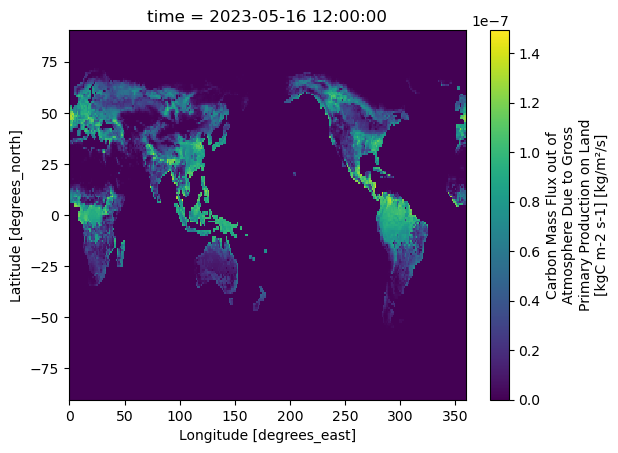

In [66]:
ds_dict[list(ds_dict.keys())[0]].gpp.isel(time=100).plot()

#### Select period or work with time problems

In [271]:
import xarray as xr
import numpy as np
import cftime

def add_missing_year(ds, start_year=2015, end_year=2100):
    """
    Adds missing time steps for the last year with NaN values for each variable.
    
    Parameters:
    - ds: xarray Dataset to add missing time steps.
    - start_year: The starting year of the dataset.
    - end_year: The ending year to include in the dataset.
    
    Returns:
    - Updated xarray Dataset with added NaN values for the missing year.
    """
    # Generate time steps for the missing last year (12 months for 2100)
    missing_time_range = xr.cftime_range(start=f'{end_year}-01-01', end=f'{end_year}-12-31', freq='M', calendar='noleap')

    # Create a new dataset with the missing time steps and NaN values
    nan_data = xr.Dataset(
        {var: (('time', 'lat', 'lon'), np.full((len(missing_time_range), ds.dims['lat'], ds.dims['lon']), np.nan, dtype=np.float32))
         for var in ds.data_vars},
        coords={
            'time': missing_time_range,
            'lat': ds['lat'],
            'lon': ds['lon']
        }
    )

    # Concatenate the original dataset with the NaN dataset along the time dimension
    ds_combined = xr.concat([ds, nan_data], dim='time')
    
    return ds_combined

# Example usage
# Assuming ds_dict is already loaded as per your previous context
model_name = list(ds_dict.keys())[0]
ds = ds_dict[model_name]
ds_updated = add_missing_year(ds)

# Update the dataset in the dictionary
ds_dict[model_name] = ds_updated

# Verify the updated dataset
print(ds_dict[model_name])

<xarray.Dataset>
Dimensions:  (time: 1032, lat: 160, lon: 320)
Coordinates:
  * time     (time) object 2015-01-16 12:00:00 ... 2100-12-31 00:00:00
  * lat      (lat) float64 -89.14 -88.03 -86.91 -85.79 ... 86.91 88.03 89.14
  * lon      (lon) float64 0.0 1.125 2.25 3.375 4.5 ... 355.5 356.6 357.8 358.9
Data variables:
    lai      (time, lat, lon) float32 dask.array<chunksize=(1020, 160, 320), meta=np.ndarray>
    mrro     (time, lat, lon) float32 dask.array<chunksize=(1020, 160, 320), meta=np.ndarray>
    mrso     (time, lat, lon) float32 dask.array<chunksize=(1020, 160, 320), meta=np.ndarray>
    tran     (time, lat, lon) float32 dask.array<chunksize=(1020, 160, 320), meta=np.ndarray>
    evspsbl  (time, lat, lon) float32 dask.array<chunksize=(1020, 160, 320), meta=np.ndarray>
    pr       (time, lat, lon) float32 dask.array<chunksize=(1020, 160, 320), meta=np.ndarray>
    ps       (time, lat, lon) float32 dask.array<chunksize=(1020, 160, 320), meta=np.ndarray>
    tas      (time, la

In [240]:
ds_dict = select_period(ds_dict, start_year=1850, end_year=2100)

In [118]:
for name, ds in ds_dict.items():
    # Select only the time steps without 999999 microseconds
    ds_cleaned = ds.sel(time=~(ds['time'].dt.microsecond == 999999))
    ds_dict[name] = ds_cleaned

In [239]:
from cftime import DatetimeNoLeap, DatetimeGregorian, Datetime360Day
def select_period(ds_dict, start_year=None, end_year=None):
    '''
    Helper function to select periods.
    
    Parameters:
    ds_dict (dict): Dictionary with xarray datasets.
    start_year (int): The start year of the period.
    end_year (int): The end year of the period.
    """
    '''
    start_year = DatetimeGregorian(start_year, 1, 16, 12, 0, 0, 0,has_year_zero=True) # 16th of January of start year
    end_year = DatetimeGregorian(end_year, 12, 16, 12, 0, 0, 0, has_year_zero=True) # 16th of December of end year
    ds_dict = {k: v.sel(time=slice(start_year, end_year)) for k, v in ds_dict.items()}
    
    return ds_dict

In [59]:
import cftime

# Assuming your dataset is named ds
ds = ds_dict_1[list(ds_dict_1.keys())[0]]

# Extract the February data
feb_data = ds.sel(time=ds['time'][0])

# Modify the time value to January 15th
feb_data['time'] = cftime.DatetimeNoLeap(2015, 1, 16, 12, 0, 0, 0, has_year_zero=True)

# Concatenate this new data with the original dataset
new_ds = xr.concat([feb_data, ds], dim='time').sortby('time')

ds_dict_1[list(ds_dict_1.keys())[0]] = new_ds

#### Converting daily to monthly

In [249]:
# Compute monthly mean for the 'pr' variable
ds_dict[list(ds_dict.keys())[0]] = ds_dict[list(ds_dict.keys())[0]].resample(time='M').mean('time')

### Hurs approximated from hur

In [14]:
ds_dict[list(ds_dict.keys())[0]]['hurs'] = ds_dict[list(ds_dict.keys())[0]].hur.isel(plev=0)

In [15]:
ds_dict[list(ds_dict.keys())[0]] = ds_dict[list(ds_dict.keys())[0]].drop(['hur', 'plev'])

In [16]:
ds_dict[list(ds_dict.keys())[0]]

<xarray.Dataset>
Dimensions:  (lat: 192, lon: 288, time: 1032)
Coordinates:
  * lat      (lat) float64 -90.0 -89.06 -88.12 -87.17 ... 87.17 88.12 89.06 90.0
  * lon      (lon) float64 0.0 1.25 2.5 3.75 5.0 ... 355.0 356.2 357.5 358.8
  * time     (time) object 2015-01-16 12:00:00 ... 2100-12-16 12:00:00
Data variables:
    hurs     (time, lat, lon) float32 dask.array<chunksize=(18, 192, 288), meta=np.ndarray>
Attributes: (12/55)
    Conventions:               CF-1.7 CMIP-6.2
    activity_id:               ScenarioMIP AerChemMIP
    branch_method:             Hybrid-restart from year 2015-01-01 of historical
    branch_time:               0.0
    branch_time_in_child:      0.0
    branch_time_in_parent:     60225.0
    ...                        ...
    variant_label:             r1i1p1f1
    netcdf_tracking_ids:       hdl:21.14100/a254be33-127c-4bf1-b9b5-36e2fd798...
    version_id:                v20191108
    intake_esm_varname:        ['hur']
    intake_esm_dataset_key:    ScenarioMIP.NCC.NorESM2-MM.ssp370.Amon.gn
    log:                       Dropped: time_bnds. // Dropped: lon_bnds. // D...

### CO2 Approach

In [106]:
import copy

# Copy the ds to a new key
new_key = 'NorESM2-MM'
new_dataset = copy.deepcopy(surface_co2)
ds_dict[new_key] = new_dataset

# Verify the dataset is copied under the new key
print(ds_dict.keys()) 

dict_keys(['BCC-CSM2-MR', 'NorESM2-MM', 'TaiESM1', 'CanESM5', 'CNRM-CM6-1', 'CNRM-ESM2-1', 'IPSL-CM6A-LR', 'UKESM1-0-LL', 'MPI-ESM1-2-LR', 'CESM2-WACCM'])


In [107]:
# Iterate over the ds_dict keys
for key in ds_dict.keys():
    ds = ds_dict[key]  # Get the dataset
    ds.attrs['source_id'] = key  # Update the source_id attribute

    # Assign the modified dataset back to the ds_dict
    ds_dict[key] = ds

In [109]:
ds_dict.keys()

dict_keys(['BCC-CSM2-MR', 'NorESM2-MM', 'TaiESM1', 'CanESM5', 'CNRM-CM6-1', 'CNRM-ESM2-1', 'IPSL-CM6A-LR', 'UKESM1-0-LL', 'MPI-ESM1-2-LR', 'CESM2-WACCM'])

In [112]:
ds_dict[list(ds_dict.keys())[2]].source_id

'TaiESM1'

In [21]:
# Constants
molar_mass_co2 = 44.01  # Molar mass of CO2 in grams per mole (g/mol)
conversion_factor = 1e6  # Conversion factor from ppm to unitless (parts per million to mole fraction)

# Convert mole fraction to ppm
co2_concentration_ppm = ds_dict[list(ds_dict.keys())[1]]['co2'] * conversion_factor

In [22]:
# Update the variable attributes
co2_concentration_ppm.attrs['units'] = 'ppm'
# Assign the converted variable back to the dataset
ds_dict[list(ds_dict.keys())[1]]['co2'] = co2_concentration_ppm

In [23]:
ds_dict[list(ds_dict.keys())[1]].co2

<xarray.DataArray 'co2' (time: 1032, plev: 19, lat: 192, lon: 288)>
dask.array<mul, shape=(1032, 19, 192, 288), dtype=float32, chunksize=(61, 19, 192, 288), chunktype=numpy.ndarray>
Coordinates:
  * lat      (lat) float64 -90.0 -89.06 -88.12 -87.17 ... 87.17 88.12 89.06 90.0
  * lon      (lon) float64 0.0 1.25 2.5 3.75 5.0 ... 355.0 356.2 357.5 358.8
  * plev     (plev) float64 1e+05 9.25e+04 8.5e+04 7e+04 ... 1e+03 500.0 100.0
  * time     (time) object 2015-01-15 12:00:00 ... 2100-12-15 12:00:00
Attributes:
    units:    ppm

In [17]:
ds_dict[list(ds_dict.keys())[0]]

<xarray.Dataset>
Dimensions:  (time: 1032, plev: 19, lat: 160, lon: 320)
Coordinates:
  * lat      (lat) float64 -89.14 -88.03 -86.91 -85.79 ... 86.91 88.03 89.14
  * lon      (lon) float64 0.0 1.125 2.25 3.375 4.5 ... 355.5 356.6 357.8 358.9
  * plev     (plev) float64 1e+05 9.25e+04 8.5e+04 7e+04 ... 1e+03 500.0 100.0
  * time     (time) object 2015-01-16 12:00:00 ... 2100-12-16 12:00:00
Data variables:
    co2      (time, plev, lat, lon) float32 dask.array<chunksize=(25, 19, 160, 320), meta=np.ndarray>
Attributes: (12/55)
    Conventions:             CF-1.7 CMIP-6.2
    activity_id:             ScenarioMIP
    branch_method:           Standard
    branch_time_in_child:    0.0
    branch_time_in_parent:   2015.0
    cmor_version:            3.3.2
    ...                      ...
    variant_label:           r1i1p1f1
    netcdf_tracking_ids:     hdl:21.14100/df11ff3b-317b-4972-abf6-fee179682b2...
    version_id:              v20190314
    intake_esm_varname:      ['co2']
    intake_esm_dataset_key:  ScenarioMIP.BCC.BCC-CSM2-MR.ssp370.Amon.gn
    log:                     Dropped: time_bnds. // Dropped: lon_bnds. // Dro...

In [95]:
ds_dict[list(ds_dict.keys())[0]] = surface_co2

In [89]:
surface_co2.co2

<xarray.DataArray 'co2' (time: 1980, lat: 160, lon: 320)>
dask.array<getitem, shape=(1980, 160, 320), dtype=float32, chunksize=(495, 160, 320), chunktype=numpy.ndarray>
Coordinates:
  * lat      (lat) float64 -89.14 -88.03 -86.91 -85.79 ... 86.91 88.03 89.14
  * lon      (lon) float64 0.0 1.125 2.25 3.375 4.5 ... 355.5 356.6 357.8 358.9
  * time     (time) object 1850-01-16 12:00:00 ... 2014-12-16 12:00:00
Attributes:
    units:      ppm
    long_name:  Surface CO2 Concentration
    Log:        CO2 concentration at plev=100000

In [31]:
surface_co2 = ds_dict[list(ds_dict.keys())[1]].sel(plev=100000)

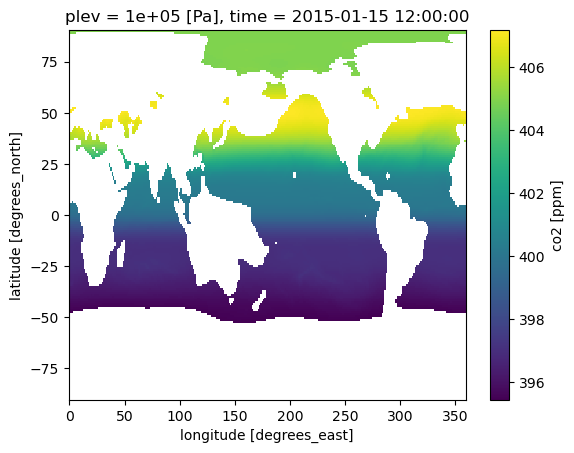

In [32]:
surface_co2.co2.isel(time=0).plot()

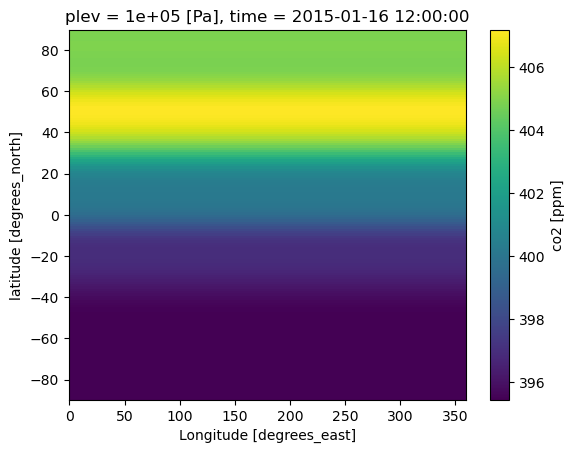

In [30]:
surface_co2.co2.isel(time=0).plot()

### 3. Save Data as netCDF

In [67]:
# =========== Store file and remove any former one ==========
# Base directory
data_state = 'raw'
data_path = f'{data_state}/CMIP6/ssp370/month/'
file_path = os.path.join(BASE_DIR, data_path)
print(file_path)

/work/ch0636/g300115/phd_project/common/data/raw/CMIP6/ssp370/month/


In [68]:
sd.save_files(ds_dict, file_path)

File /work/ch0636/g300115/phd_project/common/data/raw/CMIP6/ssp370/month/evspsbl/NorESM2-MM.nc removed
File saved at: /work/ch0636/g300115/phd_project/common/data/raw/CMIP6/ssp370/month/evspsbl/NorESM2-MM.nc
File /work/ch0636/g300115/phd_project/common/data/raw/CMIP6/ssp370/month/huss/NorESM2-MM.nc removed
File saved at: /work/ch0636/g300115/phd_project/common/data/raw/CMIP6/ssp370/month/huss/NorESM2-MM.nc
File /work/ch0636/g300115/phd_project/common/data/raw/CMIP6/ssp370/month/pr/NorESM2-MM.nc removed
File saved at: /work/ch0636/g300115/phd_project/common/data/raw/CMIP6/ssp370/month/pr/NorESM2-MM.nc
File /work/ch0636/g300115/phd_project/common/data/raw/CMIP6/ssp370/month/ps/NorESM2-MM.nc removed
File saved at: /work/ch0636/g300115/phd_project/common/data/raw/CMIP6/ssp370/month/ps/NorESM2-MM.nc
File /work/ch0636/g300115/phd_project/common/data/raw/CMIP6/ssp370/month/tas/NorESM2-MM.nc removed
File saved at: /work/ch0636/g300115/phd_project/common/data/raw/CMIP6/ssp370/month/tas/NorESM2-